In [3]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import torchvision
import cv2
import torch
import torch.nn
import pandas as pd 
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torch.optim import Adam, AdamW
from torch.nn import CrossEntropyLoss
from tqdm import tqdm, trange
import math
import numpy as np
from einops import rearrange
from VisionTransformer import ViTForClassfication

In [4]:
label_df = pd.read_csv('./FracAtlas/dataset.csv')
# Upsample fractured samples in training data

# Separate fractured and unfractured samples
fractured_df = label_df[label_df['fractured'] == 1]
unfractured_df = label_df[label_df['fractured'] == 0]

# Split the fractured and unfractured data into training and validation sets
train_frac_df, val_frac_df = train_test_split(fractured_df, test_size=0.2)
train_unfrac_df, val_unfrac_df = train_test_split(unfractured_df, test_size=0.2)

num_unfrac = len(train_unfrac_df)
num_frac = len(train_frac_df)

if num_frac < num_unfrac:
    # Calculate how many more fractured samples are needed
    difference = num_unfrac - num_frac
    
    # Upsample fractured data by duplicating random samples with replacement
    upsampled_train_frac_df = train_frac_df.sample(difference, replace=True, random_state=42)
    
    # Concatenate the upsampled fractured samples with the original fractured data
    train_frac_df = pd.concat([train_frac_df, upsampled_train_frac_df])

# Concatenate upsampled fractured data with unfractured data
train_df = pd.concat([train_frac_df, train_unfrac_df])

# Concatenate validation sets without upsampling
val_df = pd.concat([val_frac_df, val_unfrac_df])

# Reset index for both train and validation dataframes
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

# Shuffle the training set
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

# val_df = val_df[val_df['fractured'] == 1]
# val_df.shape

In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, annotation_df, img_dir, transform=None, target_transform=None):
        self.img_labels = annotation_df
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.loc[idx, 'image_id'])
#         print(img_path)
        image = cv2.imread(img_path)
        image = np.transpose(image, (2, 0, 1))
        image = torch.tensor(image, dtype= torch.float32)
        
#         image = torch.tensor(image).unsqueeze(0)
        label = self.img_labels.loc[idx, 'fractured']
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

# class CustomImageDataset(Dataset):
#     def __init__(self, annotation_df, img_dir, transform=None, target_transform=None):
#         self.img_labels = annotation_df
#         self.img_dir = img_dir
#         self.transform = transform
#         self.target_transform = target_transform

#     def __len__(self):
#         return len(self.img_labels)

#     def __getitem__(self, idx):
#         img_path = os.path.join(self.img_dir, self.img_labels.loc[idx, 'image_id'])
# #         print(img_path)
#         image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
#         image = torch.tensor(image, dtype= torch.float32).unsqueeze(0)
# #         image = torch.tensor(image).unsqueeze(0)
#         label = self.img_labels.loc[idx, 'fractured']
#         if self.transform:
#             image = self.transform(image)
#         if self.target_transform:
#             label = self.target_transform(label)
#         return image, label

Feature batch shape: torch.Size([32, 3, 500, 500])


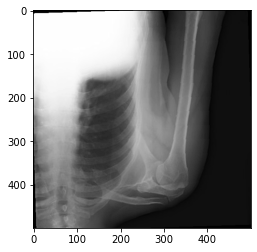

Label: 0


In [7]:
# Configuration for the ViT model (you can adjust these as per your model design)
config = {
    "encoding_size": 256,
    "num_classes": 2,
    "num_heads": 2,
    "img_dim": 500,
    "patch_size": 20,
    "dropout": 0.3,
    'num_hidden_layers': 1,
    'intermediate_size': 1024,
    'channels': 3
}

# config = {
#     "encoding_size": 128,  # Change this according to your ViT model
#     "num_classes": 2,     # MNIST has 10 output classes (digits 0-9)
#     "num_heads": 8,
#     "img_dim": 256,         # Resize the MNIST images to 32x32
#     "patch_size": 8,       # Assuming 32x32 images, patch size = 4 means 8x8 patches
#     "dropout": 0.1,
#     'num_hidden_layers': 3,
#     'intermediate_size': 4*128,
# }

transform = transforms.Compose([
    transforms.Resize(config['img_dim']),
    transforms.CenterCrop(config['img_dim']),
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),  # Randomly rotate the image
#     transforms.ColorJitter(brightness=0.5, contrast=0.5),  # Adjust brightness and contrast
    transforms.Normalize(mean=[0.5], std=[0.5])
    
])


train_dataset = CustomImageDataset(train_df, './FracAtlas/images/Compiled/', transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = CustomImageDataset(val_df, './FracAtlas/images/Compiled/', transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)


train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img[0], cmap="gray")
plt.show()
print(f"Label: {label}")

In [8]:
def train(N_EPOCHS, criterion, optimizer, model):
    # Training loop
    for epoch in trange(N_EPOCHS, desc="Training"):
        train_loss = 0.0
        iteration = 0  # To track the number of iterations

        for batch in tqdm(train_dataloader, desc=f"Epoch {epoch + 1} in training", leave=False):
            iteration += 1

            # Training Step
            x, y = batch
            x, y = x.cuda(), y.cuda()  # Assuming you're using a GPU
            y_hat = model(x)
            loss = criterion(y_hat, y)

            train_loss += loss.detach().cpu().item() / len(train_dataloader)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Validation step after every 10 iterations
            if iteration % 10 == 0:
                val_loss = 0.0
                correct = 0
                total = 0

                model.eval()  # Set the model to evaluation mode
                with torch.no_grad():  # Disable gradient computation
                    for val_batch in tqdm(val_dataloader):
                        val_x, val_y = val_batch
                        val_x, val_y = val_x.cuda(), val_y.cuda()

                        val_y_hat = model(val_x)
                        val_loss += criterion(val_y_hat, val_y).item() / len(val_dataloader)

                        # Calculate accuracy
                        _, predicted = torch.max(val_y_hat, 1)
                        correct += (predicted == val_y).sum().item()
                        total += val_y.size(0)

                val_accuracy = correct / total

                print(f"Iteration {iteration}: Validation Loss: {val_loss:.2f}, Validation Accuracy: {val_accuracy:.2f}")
                model.train()  # Switch back to training mode
                print(f"Iteration {iteration}: Training Loss: {loss:.2f}")

        print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")

In [9]:
from torchvision import models

# resnet = models.resnet50(pretrained=True)
# num_ftrs = resnet.fc.in_features
# resnet.fc = nn.Linear(num_ftrs, 2)  
# resnet = resnet.cuda()

N_EPOCHS = 5

# # Model (replace `ViTForClassification` with your actual ViT class name)
vit = ViTForClassfication(config)
vit = vit.cuda()  

optimizer = AdamW(vit.parameters(), lr=1e-4, weight_decay=0.05)
criterion = nn.CrossEntropyLoss()

train(N_EPOCHS, criterion, optimizer, vit)

Training:   0%|                                                                                  | 0/5 [00:16<?, ?it/s]


KeyboardInterrupt: 

In [113]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import trange, tqdm

# Configuration for the ViT model (you can adjust these as per your model design)
config = {
    "encoding_size": 128,  # Change this according to your ViT model
    "num_classes": 10,     # MNIST has 10 output classes (digits 0-9)
    "num_heads": 8,
    "img_dim": 32,         # Resize the MNIST images to 32x32
    "patch_size": 4,       # Assuming 32x32 images, patch size = 4 means 8x8 patches
    "dropout": 0.1,
    'num_hidden_layers': 3,
    'intermediate_size': 4*128,
}

# Model (replace `ViTForClassification` with your actual ViT class name)
model = ViTForClassfication(config)
model = model.cuda()  # Move the model to the GPU

# Preprocessing and loading the MNIST dataset
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize the 28x28 images to 32x32
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1] range
])

# Load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
val_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Create DataLoader for training and validation
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Optimizer and loss function
optimizer = Adam(model.parameters(), lr=0.001)
criterion = CrossEntropyLoss()

train(N_EPOCHS, criterion, optimizer, model)

Epoch 1 in training:   1%|▎                                                            | 5/938 [00:00<01:07, 13.76it/s]

  0%|                                                                                          | 0/157 [00:00<?, ?it/s]

  4%|███▏                                                                              | 6/157 [00:00<00:02, 58.12it/s]

  8%|██████▏                                                                          | 12/157 [00:00<00:02, 56.56it/s]

 11%|█████████▎                                                                       | 18/157 [00:00<00:02, 56.32it/s]

 15%|████████████▍                                                                    | 24/157 [00:00<00:02, 53.48it/s]

 19%|███████████████▍                                                                 | 30/157 [00:00<00:02, 52.32it/s]

 23%|██████████████████▌                                                              | 36/157 [00:00<00:02, 53.00it/s]

 27%|█████████████████████▋     

Iteration 10: Validation Loss: 2.35, Validation Accuracy: 0.10
Iteration 10: Training Loss: 2.45



Epoch 1 in training:   2%|█▏                                                          | 18/938 [00:03<02:32,  6.04it/s]

  0%|                                                                                          | 0/157 [00:00<?, ?it/s]

  4%|███▏                                                                              | 6/157 [00:00<00:02, 55.13it/s]

  8%|██████▏                                                                          | 12/157 [00:00<00:02, 56.32it/s]

 11%|█████████▎                                                                       | 18/157 [00:00<00:02, 56.94it/s]

 15%|████████████▍                                                                    | 24/157 [00:00<00:02, 57.40it/s]

 19%|███████████████▍                                                                 | 30/157 [00:00<00:02, 56.87it/s]

 23%|██████████████████▌                                                              | 36/157 [00:00<00:02, 56.46it/s]

 27%|█████████████████████▋    

Iteration 20: Validation Loss: 2.20, Validation Accuracy: 0.16
Iteration 20: Training Loss: 2.18



Epoch 1 in training:   3%|█▊                                                          | 29/938 [00:07<03:07,  4.84it/s]

  0%|                                                                                          | 0/157 [00:00<?, ?it/s]

  4%|███▏                                                                              | 6/157 [00:00<00:02, 51.95it/s]

  8%|██████▏                                                                          | 12/157 [00:00<00:02, 51.77it/s]

 11%|█████████▎                                                                       | 18/157 [00:00<00:02, 51.77it/s]

 15%|████████████▍                                                                    | 24/157 [00:00<00:02, 52.72it/s]

 19%|███████████████▍                                                                 | 30/157 [00:00<00:02, 49.96it/s]

 23%|██████████████████▌                                                              | 36/157 [00:00<00:02, 47.92it/s]

 26%|█████████████████████▏    

Iteration 30: Validation Loss: 1.80, Validation Accuracy: 0.35
Iteration 30: Training Loss: 1.89




  0%|                                                                                          | 0/157 [00:00<?, ?it/s]

  4%|███▏                                                                              | 6/157 [00:00<00:02, 57.67it/s]

  8%|██████▏                                                                          | 12/157 [00:00<00:02, 56.85it/s]

 11%|█████████▎                                                                       | 18/157 [00:00<00:02, 57.20it/s]

 15%|████████████▍                                                                    | 24/157 [00:00<00:02, 57.59it/s]

 19%|███████████████▍                                                                 | 30/157 [00:00<00:02, 57.58it/s]

 23%|██████████████████▌                                                              | 36/157 [00:00<00:02, 57.43it/s]

 27%|█████████████████████▋                                                           | 42/157 [00:00<00:02, 56.02it/s]

 31%|████████████████████████▊

Iteration 40: Validation Loss: 1.24, Validation Accuracy: 0.58
Iteration 40: Training Loss: 1.06



Epoch 1 in training:   5%|███                                                         | 48/938 [00:13<03:16,  4.53it/s]

  0%|                                                                                          | 0/157 [00:00<?, ?it/s]

  4%|███▏                                                                              | 6/157 [00:00<00:02, 53.17it/s]

  8%|██████▏                                                                          | 12/157 [00:00<00:02, 54.82it/s]

 11%|█████████▎                                                                       | 18/157 [00:00<00:02, 55.37it/s]

 15%|████████████▍                                                                    | 24/157 [00:00<00:02, 55.48it/s]

 19%|███████████████▍                                                                 | 30/157 [00:00<00:02, 55.63it/s]

 23%|██████████████████▌                                                              | 36/157 [00:00<00:02, 55.41it/s]

 27%|█████████████████████▋    

Iteration 50: Validation Loss: 0.85, Validation Accuracy: 0.72
Iteration 50: Training Loss: 0.89



Epoch 1 in training:   6%|███▊                                                        | 59/938 [00:16<03:00,  4.87it/s]

  0%|                                                                                          | 0/157 [00:00<?, ?it/s]

  4%|███▏                                                                              | 6/157 [00:00<00:02, 57.43it/s]

  8%|██████▏                                                                          | 12/157 [00:00<00:02, 57.30it/s]

 11%|█████████▎                                                                       | 18/157 [00:00<00:02, 57.25it/s]

 15%|████████████▍                                                                    | 24/157 [00:00<00:02, 57.72it/s]

 19%|███████████████▍                                                                 | 30/157 [00:00<00:02, 57.81it/s]

 23%|██████████████████▌                                                              | 36/157 [00:00<00:02, 57.97it/s]

 27%|█████████████████████▋    

Iteration 60: Validation Loss: 0.76, Validation Accuracy: 0.73
Iteration 60: Training Loss: 0.83




  0%|                                                                                          | 0/157 [00:00<?, ?it/s]

  4%|███▏                                                                              | 6/157 [00:00<00:02, 54.43it/s]

  8%|██████▏                                                                          | 12/157 [00:00<00:02, 56.49it/s]

 11%|█████████▎                                                                       | 18/157 [00:00<00:02, 56.22it/s]

 15%|████████████▍                                                                    | 24/157 [00:00<00:02, 56.03it/s]

 19%|███████████████▍                                                                 | 30/157 [00:00<00:02, 55.65it/s]

 23%|██████████████████▌                                                              | 36/157 [00:00<00:02, 55.79it/s]

 27%|█████████████████████▋                                                           | 42/157 [00:00<00:02, 55.89it/s]

 31%|████████████████████████▊

Iteration 70: Validation Loss: 0.67, Validation Accuracy: 0.77
Iteration 70: Training Loss: 0.78



Epoch 1 in training:   8%|█████                                                       | 79/938 [00:23<02:52,  4.97it/s]

  0%|                                                                                          | 0/157 [00:00<?, ?it/s]

  4%|███▏                                                                              | 6/157 [00:00<00:02, 56.82it/s]

  8%|██████▏                                                                          | 12/157 [00:00<00:02, 56.21it/s]

 11%|█████████▎                                                                       | 18/157 [00:00<00:02, 53.68it/s]

 15%|████████████▍                                                                    | 24/157 [00:00<00:02, 53.67it/s]

 19%|███████████████▍                                                                 | 30/157 [00:00<00:02, 53.64it/s]

 23%|██████████████████▌                                                              | 36/157 [00:00<00:02, 53.87it/s]

 27%|█████████████████████▋    

Iteration 80: Validation Loss: 0.52, Validation Accuracy: 0.83
Iteration 80: Training Loss: 0.77




  0%|                                                                                          | 0/157 [00:00<?, ?it/s]

  4%|███▏                                                                              | 6/157 [00:00<00:02, 56.36it/s]

  8%|██████▏                                                                          | 12/157 [00:00<00:02, 56.32it/s]

 11%|█████████▎                                                                       | 18/157 [00:00<00:02, 55.97it/s]

 15%|████████████▍                                                                    | 24/157 [00:00<00:02, 56.60it/s]

 19%|███████████████▍                                                                 | 30/157 [00:00<00:02, 55.82it/s]

 23%|██████████████████▌                                                              | 36/157 [00:00<00:02, 56.44it/s]

 27%|█████████████████████▋                                                           | 42/157 [00:00<00:02, 57.11it/s]

 31%|████████████████████████▊

KeyboardInterrupt: 

In [58]:
train_df.shape

(5384, 13)